In [1]:
import torch
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    # Set the current device to the first GPU
    device = torch.device("cuda:0")
    # If there are multiple GPUs, you can set the current device to 'cuda:0' and use DataParallel
    if num_gpus > 1:
        device = torch.device("cuda:0")
        
        print(f"Using {num_gpus} GPUs.")
    else:
        print("Using a single GPU.")
else:
    device = torch.device("cpu")
print(device)

cpu


# **DataLoader**

In [2]:
import os
import torch.utils.data as data
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import random
import cv2
import tensorflow as tf
from torch.autograd import Variable
def find_classes(root):
    classes = [d for d in os.listdir(root)]
    classes.sort()
    class_to_idex = {classes[i]: i for i in range(len(classes))}
    index_to_class = {i: classes[i] for i in range(len(classes))}
    return classes, class_to_idex, index_to_class

def make_dataset(root):
    images = []

    cnames = os.listdir(root)
    for cname in cnames:
        c_path = os.path.join(root, cname)
        fnames = os.listdir(c_path)
        for fname in fnames:
            path = os.path.join(c_path, fname)
            images.append(path)

    return images


class TripleDataset(data.Dataset):
    def __init__(self, photo_root, sketch_root, batch_size=32):
        super(TripleDataset, self).__init__()
        self.tranform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        classes, class_to_idx, idx_to_class = find_classes(photo_root)

        self.photo_root = photo_root
        self.sketch_root = sketch_root
        
        self.anchor_images = sorted(make_dataset(self.sketch_root))
        
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.idx_to_class = idx_to_class

        self.batch_size = batch_size
        self.len = len(self.anchor_images)
        self.num_batches = len(self.anchor_images) // self.batch_size
        
    def __getitem__(self, index):
        anchor_data = self.anchor_images[index]
        pos_data, label = self._getrelate_photo(anchor_data)
        neg_data = self._getneg_photo(anchor_data)

        po = Image.open(pos_data).convert('RGB')
        an = Image.open(anchor_data).convert('RGB')
        ne = Image.open(neg_data).convert('RGB')

        A = self.tranform(an)
        P = self.tranform(po)
        L = str(label)
        N = self.tranform(ne)
        
        return {'A': A, 'P': P, 'N': N, 'L': L}
    
    def __len__(self):
        return self.len
    def __iter__(self):
        for index in range(len(self)):
            yield self[index]
    
    def _getrelate_photo(self, anchor_filename):
        paths = anchor_filename.split('/')
        fname = paths[-1].split('-')[0]
        cname = paths[-2]

        label = self.class_to_idx[cname]
        
        pos = '0'
        photos = os.listdir(os.path.join(self.photo_root, cname))

        for photo_name in photos:
            name = photo_name.split('.')[0]
            if  name == fname:
                pos = os.path.join(self.photo_root, cname, photo_name)
        return pos, label
    
    def _getneg_photo(self, anchor_filename):
        paths = anchor_filename.split('/')
        fname = paths[-1].split('-')[0]
        cname = paths[-2]

        label = self.class_to_idx[cname]
        if label == 0:
            r = list(range(label+1,10))
        else:
            r = list(range(0,label))+list(range(label+1,10))
        i = random.choice(r) #class
        negative_class = self.idx_to_class[i]


        negative_image = random.choice(os.listdir(os.path.join(self.photo_root, 
                                                               negative_class)))  
        return os.path.join(self.photo_root,negative_class, negative_image)

In [3]:
class TripleDataLoader(data.Dataset):
    def __init__(self, opt):
        self.dataset = TripleDataset(opt.photo_root, opt.sketch_root)
        self.dataloader = data.DataLoader(
            self.dataset,
            shuffle=True,
            batch_size=opt.batch_size,
            num_workers=4,
            drop_last=True
        )

    def load_data(self):
        return self

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):
        for i, data in enumerate(self.dataloader):
            yield data

# **Create model**

In [4]:
import os
%cd /kaggle/working/
os.makedirs('/kaggle/working/model', exist_ok=True)

/kaggle/working


In [8]:
# %%writefile vgg.py
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import math

__all__ = [
    'VGG', 'vgg16',
]


model_urls = {
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        print('feature.size()', x.size()) 
        x = x.view(x.size(0), -1)
        feature = x

        return feature

    #khởi tạo trọng số pretrained on ImageNet
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #vgg13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #vgg16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'], #vgg19
}


def vgg16(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16']))
    return model

# **Training**

In [9]:
import torch as t
from torch import nn
from torch.nn import DataParallel

import os
import numpy as np
from torch.autograd import Variable


class Config(object):
    def __init__(self):
        return

class TripletNet(object):

    def __init__(self, opt):
        # train config
        self.photo_root = opt.photo_root
        self.sketch_root = opt.sketch_root
        self.batch_size = opt.batch_size
        self.device = opt.device
        self.epochs = opt.epochs
        self.lr = opt.lr

        self.save_dir = opt.save_dir

        # dataloader config
        data_opt = Config()
        data_opt.photo_root = opt.photo_root
        data_opt.sketch_root = opt.sketch_root
        data_opt.batch_size = opt.batch_size

        self.dataloader_opt = data_opt

        # triplet config
        self.margin = opt.margin
        self.p = opt.p

        # feature extractor net
        self.net = opt.net
        self.cat = opt.cat

    def _get_vgg16(self, pretrained=True):
        model = vgg16(pretrained=pretrained)
        return model

    def train(self):

        photo_net = self._get_vgg16().cuda()

        print('net')
        print(photo_net)

        triplet_loss = nn.TripletMarginLoss(margin=self.margin, p=self.p).cuda()

        # optimizer
        photo_optimizer = t.optim.SGD(photo_net.parameters(),lr=self.lr,
                                      weight_decay=0.0005, momentum=0.9)

        data_loader = TripleDataLoader(self.dataloader_opt)
        dataset = data_loader.load_data()
        print('Len:', len(dataset))
        loss_list = []

        for epoch in range(self.epochs):

            print('---------------{0}---------------'.format(epoch))

            photo_net.train()
            avg = 0
            count = 0
            for ii, data in enumerate(dataset):
                count = ii
                photo_optimizer.zero_grad()

                photo, sketch, neg =Variable(data['P'].cuda()), Variable(data['A'].cuda()), Variable(data['N'].cuda())

                label = data['L']
                
                s_feature = photo_net(sketch)
                p_feature = photo_net(photo)
                n_feature = photo_net(neg)
                print(s_feature.shape)
                if ii==0: break
                loss = triplet_loss(s_feature, p_feature, n_feature)
                avg += loss.item()
                loss.backward()

                photo_optimizer.step()
                
                if (ii+1)%64 == 0:
                    print('[Train] Epoch: [{0}][{1}/{2}]\t'
                            'Triplet loss  ({triplet_loss_meterr:.3f})\t'
                            .format(epoch + 1, ii + 1, len(dataset), 
                                    triplet_loss_meterr=loss.item()))
                
                del photo, sketch, neg, s_feature, p_feature, n_feature, loss
                t.cuda.empty_cache()
                
            if epoch > 0 or epoch==0:
                t.save(photo_net.state_dict(), self.save_dir + '/photo_' + self.net + '_%s.pth' % epoch)
            loss_list.append(avg/len(dataset))
        print(loss_list)
            print(count)

In [10]:
import argparse
import os

class Parser():
    def __init__(self, batch_size, device, epochs, lr):
        self.photo_root = '/kaggle/input/sketch-dataset/dataset/photo_train'
        self.sketch_root = '/kaggle/input/sketch-dataset/dataset/sketch_train'
        self.batch_size = batch_size
        self.device = device
        self.epochs = epochs
        self.lr = lr
        self.save_dir = '/kaggle/working/model'
        self.p = 2
        self.margin = 1
        self.net = 'vgg16'
        self.cat = True

def main():

    args = Parser(32, device, 1, 0.00001)
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.device)

    tripletNet = TripletNet(args)
    tripletNet.train()


if __name__ == '__main__':

    main()

net
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

# **Delete**

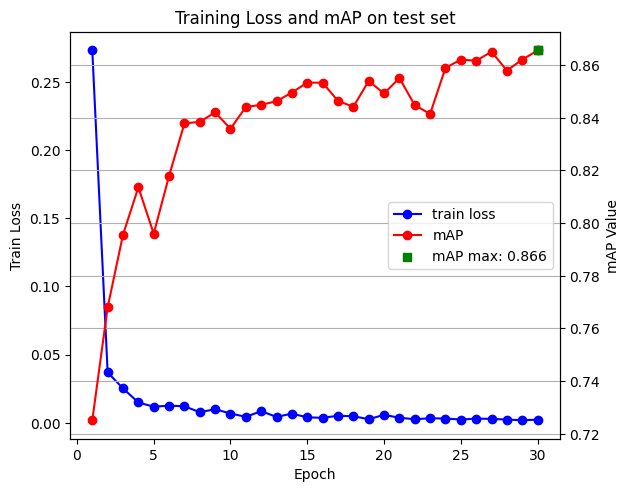

In [9]:
import matplotlib.pyplot as plt

loss_values = [0.2730399747411688, 0.03687885695404106, 0.025209672384328776, 				
 0.014859917072149424, 0.011767939462528363, 0.012515866256260371, 				
 0.012119263618976086, 0.007705897092819214, 0.00995804567437072, 				
 0.00674972250745013, 0.004353093517410172, 0.008456461704694308, 				
 0.004295891606724346, 0.006684155314118712, 0.003960574423516547, 				
 0.0036165730936543925, 0.005120224469191545, 0.004777925206231071, 				
 0.0025857140967895935, 0.0057915913891959025, 0.003665564568726333, 				
 0.002569319901766477, 0.003280992899741326, 0.0030648977189630896, 				
 0.002368404731883869, 0.0030039859401596175, 0.0028465135947807686, 				
 0.0023064104827133928, 0.0018366883684705188, 0.002251270350876388]				
 

mAP_values = [0.7251436894397196, 0.7680114143771136, 0.7955885758540215,
              0.8135915212509367, 0.7959878225382102, 0.8179267190920748,
              0.8378339433208705, 0.838451793698054, 0.8420224590887713,
              0.8358366489396282, 0.844083303623249, 0.844916012944486,
              0.8462840383772119, 0.8495785498735232, 0.8533374812781716,
              0.8533015684010419, 0.8464001386822813, 0.8441519602374008,
              0.85396301398141, 0.8492093609769138, 0.8550687945951455,
              0.8447820030044856, 0.8414589710249487, 0.8588974699912789,
              0.8620865442249541, 0.8616298330716189, 0.865080787854384,
              0.8579183566751969, 0.862094707654453, 0.8655386018470359]
epoch = range(1, 31)

# Vẽ đồ thị
fig, ax1 = plt.subplots()

color = 'blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss')
ax1.plot(epoch, loss_values, color=color, marker='o', label='train loss')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  
color = 'red'
ax2.set_ylabel('mAP Value')  
ax2.plot(epoch, mAP_values, color=color, marker='o', label='mAP')
ax2.tick_params(axis='y')
# Tìm vị trí của giá trị loss thấp nhất
min_mAP_index = mAP_values.index(max(mAP_values))
min_mAP_value = mAP_values[min_mAP_index]
ax2.plot(min_mAP_index + 1, min_mAP_value, marker='s',color='green')
ax2.scatter(min_mAP_index + 1, min_mAP_value,marker='s',color='green', label=f'mAP max: {min_mAP_value:.3f}')

fig.tight_layout()  
plt.title('Training Loss and mAP on test set')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')
plt.grid(True)
plt.show()



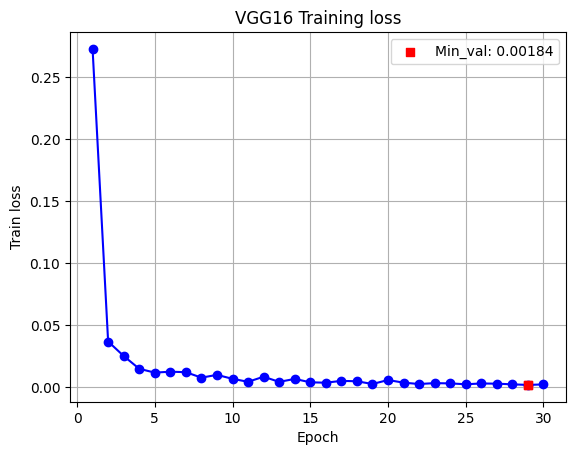

In [6]:
import matplotlib.pyplot as plt
#batch=32 lr=1e-3 m=1
epochs = range(1, 31)
loss_values = [0.2730399747411688, 0.03687885695404106, 0.025209672384328776, 				
 0.014859917072149424, 0.011767939462528363, 0.012515866256260371, 				
 0.012119263618976086, 0.007705897092819214, 0.00995804567437072, 				
 0.00674972250745013, 0.004353093517410172, 0.008456461704694308, 				
 0.004295891606724346, 0.006684155314118712, 0.003960574423516547, 				
 0.0036165730936543925, 0.005120224469191545, 0.004777925206231071, 				
 0.0025857140967895935, 0.0057915913891959025, 0.003665564568726333, 				
 0.002569319901766477, 0.003280992899741326, 0.0030648977189630896, 				
 0.002368404731883869, 0.0030039859401596175, 0.0028465135947807686, 				
 0.0023064104827133928, 0.0018366883684705188, 0.002251270350876388]				

# Vẽ đồ thị
plt.plot(epochs, loss_values, marker='o', color='blue', linestyle='-')  
plt.xlabel('Epoch')  
plt.ylabel('Train loss')  
plt.grid(True)  

min_loss_index = loss_values.index(min(loss_values))
min_loss_value = loss_values[min_loss_index]
plt.plot(min_loss_index+1, min_loss_value, marker ='s', color='red')
plt.scatter(min_loss_index + 1, min_loss_value, color='red',marker='s', label=f'Min_val: {min_loss_value:.5f}')


# # In ra điểm có giá trị nhỏ nhất trên đồ thị
# plt.text(epochs[min_loss_index], min_loss_value, f'Min loss: {min_loss_value:.4f}', 
#          horizontalalignment='left', verticalalignment='bottom')

plt.title('VGG16 Training loss')
plt.legend()
plt.show()


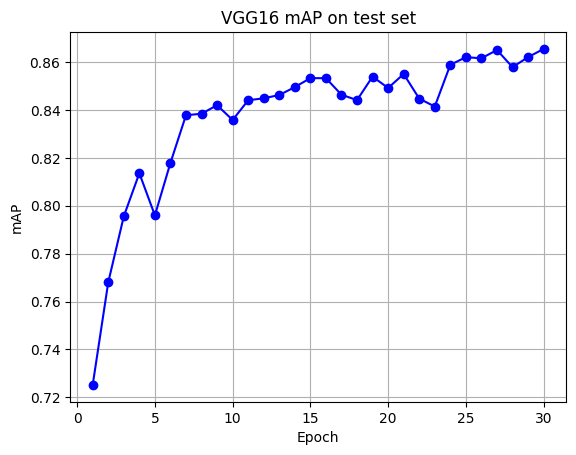

In [12]:
import matplotlib.pyplot as plt
#batch=32 lr=1e-3 m=1
epochs = range(1, 31)
mAP_values = [0.7251436894397196, 0.7680114143771136, 0.7955885758540215,
              0.8135915212509367, 0.7959878225382102, 0.8179267190920748,
              0.8378339433208705, 0.838451793698054, 0.8420224590887713,
              0.8358366489396282, 0.844083303623249, 0.844916012944486,
              0.8462840383772119, 0.8495785498735232, 0.8533374812781716,
              0.8533015684010419, 0.8464001386822813, 0.8441519602374008,
              0.85396301398141, 0.8492093609769138, 0.8550687945951455,
              0.8447820030044856, 0.8414589710249487, 0.8588974699912789,
              0.8620865442249541, 0.8616298330716189, 0.865080787854384,
              0.8579183566751969, 0.862094707654453, 0.8655386018470359]

# Vẽ đồ thị
plt.plot(epochs, mAP_values, marker='o', color='blue', linestyle='-')  
plt.xlabel('Epoch')  
plt.ylabel('mAP')  
plt.title('Line Plot')  
plt.grid(True)  

# fig.tight_layout()
plt.title('VGG16 mAP on test set')
plt.show()